The second edition of *Think DSP* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

(chapter-discrete-cosine-transform)=
# Discrete Cosine Transform

The topic of this chapter is the **Discrete Cosine Transform** (DCT), which is used in MP3 and related formats for compressing music; JPEG and similar formats for images; and the MPEG family of formats for video.

DCT is similar in many ways to the Discrete Fourier Transform (DFT), which we have been using for spectral analysis.
Once we learn how DCT works, it will be easier to explain DFT.

Here are the steps to get there:

1.  We'll start with the synthesis problem: given a set of frequency components and their amplitudes, how can we construct a wave?

2.  Next we'll rewrite the synthesis problem using NumPy arrays. This move is good for performance, and also provides insight for the next step.

3.  We'll look at the analysis problem: given a signal and a set of frequencies, how can we find the amplitude of each frequency component? We'll start with a solution that is conceptually simple but slow.

4.  Finally, we'll use some principles from linear algebra to find a more efficient algorithm. If you already know linear algebra, that's great, but I'll explain what you need as we go.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkDSP2/blob/main/soln/chap06.ipynb).

In [1]:
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
# download thinkdsp.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP2/raw/main/soln/thinkdsp.py")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import thinkdsp
from thinkdsp import decorate, decorate_time, decorate_freq, decorate_corr, decorate_gram

PI2 = np.pi * 2

(section-synthesis)=
## Synthesis

Suppose I give you a list of amplitudes and a list of frequencies, and ask you to construct a signal that is the sum of these frequency components.
Using objects in the `thinkdsp` module, there is a simple way to perform this operation, which is called **synthesis**:

In [4]:
from thinkdsp import CosSignal, SumSignal

def synthesize1(amps, fs, ts):
    components = [CosSignal(freq, amp)
                  for amp, freq in zip(amps, fs)]
    signal = SumSignal(*components)

    ys = signal.evaluate(ts)
    return ys

`amps` is a list of amplitudes, `fs` is the list of frequencies, and `ts` is the sequence of times where the signal should be evaluated.

`components` is a list of `CosSignal` objects, one for each amplitude-frequency pair.
`SumSignal` represents the sum of these frequency components.

Finally, `evaluate` computes the value of the signal at each time in `ts`.

We can test this function like this:

In [5]:
from thinkdsp import Wave

amps = np.array([0.6, 0.25, 0.1, 0.05])
fs = [100, 200, 300, 400]
framerate = 11025

ts = np.linspace(0, 1, framerate, endpoint=False)
ys1 = synthesize1(amps, fs, ts)
wave1 = Wave(ys1, ts, framerate)

This example makes a signal that contains a fundamental frequency at 100 Hz and three harmonics (100 Hz is a sharp G2).
It renders the signal for one second at 11,025 frames per second and puts the results into a Wave object.

Conceptually, synthesis is pretty simple.
But in this form it doesn't help much with **analysis**, which is the inverse problem: given the wave, how do we identify the frequency components and their amplitudes?


(section-synthesis-with-arrays)=
## Synthesis With Arrays

Here's another way to write `synthesize`:

In [6]:
def synthesize2(amps, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    ys = np.dot(M, amps)
    return ys

This function looks very different, but it does the same thing.
Let's see how it works:

1.  `np.outer` computes the outer product of `ts` and `fs`.
The result is an array with one row for each element of `ts` and one column for each element of `fs`.
Each element in the array is the product of a frequency and a time, $f   t$.

2.  We multiply `args` by $2 \pi$ and apply `cos`, so each element of the result is $\cos (2 \pi f t)$.
Since the `ts` run down the columns, each column contains a cosine signal at a particular frequency, evaluated at a sequence of times.

3.  `np.dot` multiplies each row of `M` by `amps`, element-wise, and then adds up the products.
In terms of linear algebra, we are multiplying a matrix, `M`, by a vector, ` amps`.
In terms of signals, we are computing the weighted sum of frequency components.

The following figure shows the structure of this computation.

In [7]:
#TODO: Figure here

Each row of the matrix, `M`, corresponds to a time from 0.0 to 1.0 seconds; $t_n$ is the time of the $n$th row.
Each column corresponds to a frequency from 100 to 400 Hz; $f_k$ is the frequency of the $k$th column.

I labeled the $n$th row with the letters $a$ through $d$; as an example, the value of $a$ is $\cos [2 \pi (100) t_n]$.

The result of the dot product, `ys`, is a vector with one element for each row of `M`.
The $n$th element, labeled $e$, is the sum of products:

$$e = 0.6 a + 0.25 b + 0.1 c + 0.05 d$$

And likewise with the other elements of `ys`.
So each element of `ys` is the sum of four frequency components, evaluated at a point in time, and multiplied by the corresponding amplitudes.
And that's exactly what we wanted.

We can use the code from the previous section to check that the two versions of `synthesize` produce the same results.

In [8]:
ys2 = synthesize2(amps, fs, ts)
np.max(np.abs(ys1 - ys2))

1.2789769243681803e-13

The biggest difference between `ys1` and `ys2` is about ` 1e-13`, which is what we expect due to floating-point errors.

Writing this computation in terms of linear algebra makes the code smaller and faster.
Linear algebra provides concise notation for operations on matrices and vectors.
For example, we could write `synthesize` like this:

$$\begin{aligned} M &=& \cos (2 \pi t \otimes f) \\ y &=& M a \end{aligned}$$

where $a$ is a vector of amplitudes, $t$ is a vector of times, $f$ is a vector of frequencies, and $\otimes$ is the symbol for the outer product of two vectors.


(section-analysis)=
## Analysis

Now we are ready to solve the analysis problem.
Suppose I give you a wave and tell you that it is the sum of cosines with a given set of frequencies.
How would you find the amplitude for each frequency component? In other words, given `ys`, `ts` and `fs`, can you recover `amps`?

In terms of linear algebra, the first step is the same as for synthesis: we compute $M = \cos (2 \pi t \otimes f)$.
Then we want to find $a$ so that $y = M a$; in other words, we want to solve a linear system.
NumPy provides `linalg.solve`, which does exactly that.

Here's what the code looks like:

In [9]:
def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

The first two lines use `ts` and `fs` to build the matrix, `M`.
Then `np.linalg.solve` computes `amps`.

But there's a hitch.
In general we can only solve a system of linear equations if the matrix is square; that is, the number of equations (rows) is the same as the number of unknowns (columns).

In this example, we have only 4 frequencies, but we evaluated the signal at 11,025 times.
So we have many more equations than unknowns.

In general if `ys` contains more than 4 elements, it is unlikely that we can analyze it using only 4 frequencies.

But in this case, we know that the `ys` were actually generated by adding only 4 frequency components, so we can use any 4 values from the wave array to recover `amps`.

For simplicity, I'll use the first 4 samples from the signal.
Using the values of `ys`, `fs` and `ts` from the previous section, we can run `analyze1` like this:

In [10]:
n = len(fs)
amps2 = analyze1(ys1[:n], fs, ts[:n])
amps2

array([0.6 , 0.25, 0.1 , 0.05])

And sure enough, `amps2` is the sequence of amplitudes we started with.

This algorithm works, but it is slow.
Solving a linear system of equations takes time proportional to $n^3$, where $n$ is the number of columns in $M$.
We can do better.


(section-orthogonal-matrices)=
## Orthogonal Matrices

One way to solve linear systems is by inverting matrices.
The inverse of a matrix $M$ is written $M^{-1}$, and it has the property that $M^{-1}M = I$. $I$ is the identity matrix, which has the value 1 on all diagonal elements and 0 everywhere else.

So, to solve the equation $y = Ma$, we can multiply both sides by $M^{-1}$, which yields:

$$M^{-1}y = M^{-1} M a$$

On the right side, we can replace $M^{-1}M$ with $I$:

$$M^{-1}y = I a$$

If we multiply $I$ by any vector $a$, the result is $a$, so:

$$M^{-1}y = a$$

This implies that if we can compute $M^{-1}$ efficiently, we can find $a$ with a simple matrix multiplication (using `np.dot`).
That takes time proportional to $n^2$, which is better than $n^3$.

Inverting a matrix is slow, in general, but some special cases are faster.
In particular, if $M$ is **orthogonal**, the inverse of $M$ is just the transpose of $M$, written $M^T$.
In NumPy transposing an array is a constant-time operation.
It doesn't actually move the elements of the array; instead, it creates a "view" that changes the way the elements are accessed.

Again, a matrix is orthogonal if its transpose is also its inverse; that is, $M^T = M^{-1}$.
That implies that $M^TM = I$, which means we can check whether a matrix is orthogonal by computing $M^TM$.

So let's see what the matrix looks like in `synthesize2`.
In the previous example, $M$ has 11,025 rows, so it might be a good idea to work with a smaller example:

In [11]:
# suppress scientific notation for small numbers
np.set_printoptions(precision=3, suppress=True)

amps = np.array([0.6, 0.25, 0.1, 0.05])
N = 4.0
time_unit = 0.001
ts = np.arange(N) / N * time_unit
max_freq = N / time_unit / 2
fs = np.arange(N) / N * max_freq
ys = synthesize2(amps, fs, ts)

`amps` is the same vector of amplitudes we saw before.
Since we have 4 frequency components, we'll sample the signal at 4 points in time.
That way, $M$ is square.

`ts` is a vector of equally spaced sample times in the range from 0 to 1 time unit.
I chose the time unit to be 1 millisecond, but it is an arbitrary choice, and we will see in a minute that it drops out of the computation anyway.

Since the frame rate is $N$ samples per time unit, the Nyquist frequency is `N / time_unit / 2`, which is 2000 Hz in this example.
So `fs` is a vector of equally spaced frequencies between 0 and 2000 Hz.

With these values of `ts` and `fs`, the matrix, $M$, is:

In [12]:
args = np.outer(ts, fs)
M = np.cos(PI2 * args)
M    

array([[ 1.   ,  1.   ,  1.   ,  1.   ],
       [ 1.   ,  0.707,  0.   , -0.707],
       [ 1.   ,  0.   , -1.   , -0.   ],
       [ 1.   , -0.707, -0.   ,  0.707]])

You might recognize 0.707 as an approximation of $\sqrt{2}/2$, which is $\cos \pi/4$.
You also might notice that this matrix is **symmetric**, which means that the element at $(j, k)$ always equals the element at $(k, j)$.
This implies that $M$ is its own transpose; that is, $M^T = M$.

But sadly, $M$ is not orthogonal.
If we compute $M^TM$, we get:

In [13]:
M.T @ M

array([[ 4.,  1., -0.,  1.],
       [ 1.,  2.,  1., -0.],
       [-0.,  1.,  2.,  1.],
       [ 1., -0.,  1.,  2.]])

And that's not the identity matrix.


(section-dct-iv)=
## DCT-IV

But if we choose `ts` and `fs` carefully, we can make $M$ orthogonal.
There are several ways to do it, which is why there are several versions of the discrete cosine transform (DCT).

One simple option is to shift `ts` and `fs` by a half unit.
This version is called DCT-IV, where "IV" is a roman numeral indicating that this is the fourth of eight versions of the DCT.

Here's an updated version of `test1`:

In [14]:
N = 4.0
ts = (0.5 + np.arange(N)) / N
fs = (0.5 + np.arange(N)) / 2

If you compare this to the previous version, you'll notice two changes.
First, I added 0.5 to `ts` and `fs`.
Second, I canceled out `time_units`, which simplifies the expression for `fs`.

With these values, $M$ is

In [15]:
args = np.outer(ts, fs)
M = np.cos(PI2 * args)
M    

array([[ 0.981,  0.831,  0.556,  0.195],
       [ 0.831, -0.195, -0.981, -0.556],
       [ 0.556, -0.981,  0.195,  0.831],
       [ 0.195, -0.556,  0.831, -0.981]])

And $M^TM$ is

In [16]:
M.T @ M

array([[ 2., -0.,  0.,  0.],
       [-0.,  2., -0., -0.],
       [ 0., -0.,  2., -0.],
       [ 0., -0., -0.,  2.]])

Some of the off-diagonal elements are displayed as -0, which means that the floating-point representation is a small negative number.
This matrix is very close to $2I$, which means $M$ is almost orthogonal; it's just off by a factor of 2. And for our purposes, that's good enough.

Because $M$ is symmetric and (almost) orthogonal, the inverse of $M$ is just $M/2$.
Now we can write a more efficient version of ` analyze`:

In [17]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

Instead of using `np.linalg.solve`, we just multiply by $M/2$.

Combining `test2` and `analyze2`, we can write an implementation of DCT-IV:

In [18]:
def dct_iv(ys):
    N = len(ys)
    ts = (0.5 + np.arange(N)) / N
    fs = (0.5 + np.arange(N)) / 2
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

Again, `ys` is the wave array.
We don't have to pass `ts` and `fs` as parameters; `dct_iv` can figure them out based on `N`, the length of `ys`.

If we've got it right, this function should solve the analysis problem; that is, given `ys` it should be able to recover `amps`.
We can test it like this:

In [19]:
N = 4.0
ts = (0.5 + np.arange(N)) / N
fs = (0.5 + np.arange(N)) / 2
ys = synthesize2(amps, fs, ts)
amps2 = dct_iv(ys)
max(abs(amps - amps2))

5.551115123125783e-17

Starting with `amps`, we synthesize a wave array, then use `dct_iv` to compute `amps2`.
The biggest difference between `amps` and `amps2` is about `1e-16`, which is what we expect due to floating-point errors.

(section-inverse-dct)=
## Inverse DCT

Finally, notice that `analyze2` and `synthesize2` are almost identical.
The only difference is that `analyze2` divides the result by 2. We can use this insight to compute the inverse DCT:

In [20]:
def inverse_dct_iv(amps):
    return dct_iv(amps) * 2

`inverse_dct_iv` solves the synthesis problem: it takes the vector of amplitudes and returns the wave array, `ys`.
We can test it by starting with `amps`, applying `inverse_dct_iv` and `dct_iv`, and testing that we get back what we started with.

In [21]:
amps = [0.6, 0.25, 0.1, 0.05]
ys = inverse_dct_iv(amps)
amps2 = dct_iv(ys)
max(abs(amps - amps2))

5.551115123125783e-17

Again, the biggest difference is about `1e-16`.


(section-the-dct-class)=
## The DCT Class

`thinkdsp` provides a Dct class that encapsulates the DCT in the same way the Spectrum class encapsulates the FFT.
To make a Dct object, you can invoke `make_dct` on a Wave.

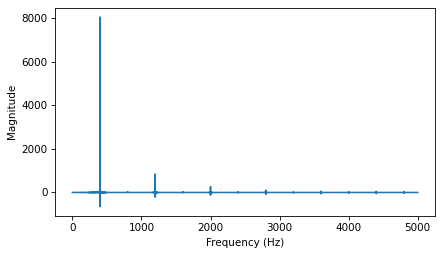

In [22]:
from thinkdsp import TriangleSignal

signal = TriangleSignal(freq=400)
wave = signal.make_wave(duration=1.0, framerate=10000)
dct = wave.make_dct()
dct.plot()
decorate_freq()

The result is the DCT of a triangle wave at 400 Hz, as shown in the following figure.
The values of the DCT can be positive or negative; a negative value in the DCT corresponds to a negated cosine or, equivalently, to a cosine shifted by 180 degrees.

`make_dct` uses DCT-II, which is the most common type of DCT, provided by `scipy.fftpack`.

In [23]:
import scipy.fftpack

# class Wave:
def make_dct(self):
    N = len(self.ys)
    hs = scipy.fftpack.dct(self.ys, type=2)
    fs = (0.5 + np.arange(N)) / 2
    return Dct(hs, fs, self.framerate)

The results from `dct` are stored in `hs`.
The corresponding frequencies, computed as in Section [\[dctiv\]](#dctiv){reference-type="ref" reference="dctiv"}, are stored in `fs`.
And then both are used to initialize the Dct object.

Dct provides `make_wave`, which performs the inverse DCT.
We can test it like this:

In [24]:
wave2 = dct.make_wave()
max(abs(wave.ys-wave2.ys))

8.881784197001252e-16

The biggest difference between `ys1` and `ys2` is about ` 1e-16`, which is what we expect due to floating-point errors.

`make_wave` uses `scipy.fftpack.idct`:

In [25]:
# class Dct
def make_wave(self):
    n = len(self.hs)
    ys = scipy.fftpack.idct(self.hs, type=2) / 2 / n
    return Wave(ys, framerate=self.framerate)

By default, the inverse DCT doesn't normalize the result, so we have to divide through by $2N$.

## Exercises

### Exercise 6.1

In this chapter I claim that `analyze1` takes time proportional to $n^3$ and `analyze2` takes time proportional to $n^2$.
To see if that's true, run them on a range of input sizes and time them.
In IPython, you can use the magic command `%timeit`.

If you plot run time versus input size on a log-log scale, you should get a straight line with slope 3 for  `analyze1` and slope 2 for `analyze2`.
You also might want to test `dct_iv` and `scipy.fftpack.dct`.

I'll start with a noise signal and an array of power-of-two sizes

In [26]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

The following function takes an array of results from a timing experiment, plots the results, and fits a straight line.

In [27]:
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests):    
    plt.plot(ns, bests)
    decorate(**loglog)
    
    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

In [28]:
def analyze1(ys, fs, ts):
    """Analyze a mixture of cosines and return amplitudes.

    Works for the general case where M is not orthogonal.

    ys: wave array
    fs: frequencies in Hz
    ts: times where the signal was evaluated    
    
    returns: vector of amplitudes
    """
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

In [29]:
def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)
        
    bests = [result.best for result in results]
    return bests

Here are the results for `analyze1`.

In [30]:
ns = 2 ** np.arange(6, 13)
ns

array([  64,  128,  256,  512, 1024, 2048, 4096])

64
153 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
538 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
256
2.38 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
14.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
73.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
416 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
2.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.3866223708327747

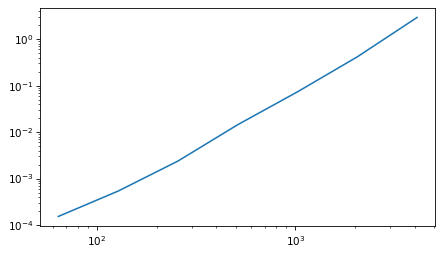

In [31]:
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

The estimated slope is close to 2, not 3, as expected.
One possibility is that the performance of `np.linalg.solve` is nearly quadratic in this range of array sizes.

Here are the results for `analyze2`:

In [32]:
def analyze2(ys, fs, ts):
    """Analyze a mixture of cosines and return amplitudes.

    Assumes that fs and ts are chosen so that M is orthogonal.

    ys: wave array
    fs: frequencies in Hz
    ts: times where the signal was evaluated    
    
    returns: vector of amplitudes
    """
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

64
89.4 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
128
339 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
256
1.42 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1,000 loops each)
512
5.19 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
40.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
129 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
890 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.2077870325037

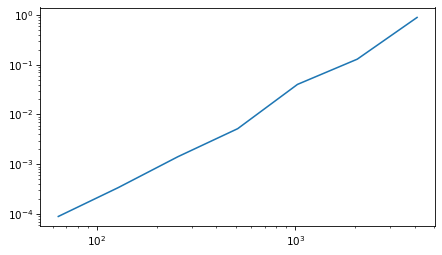

In [33]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

The results for `analyze2` fall in a straight line with the estimated slope close to 2, as expected.

Here are the results for the `scipy.fftpack.dct`

In [34]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

64
6.58 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
128
7.46 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
256
8.46 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
512
10.6 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
1024
14.5 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 100,000 loops each)
2048
24.1 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)
4096
41.3 μs ± 0 ns per loop (mean ± std. dev. of 1 run, 10,000 loops each)


0.43247225316739907

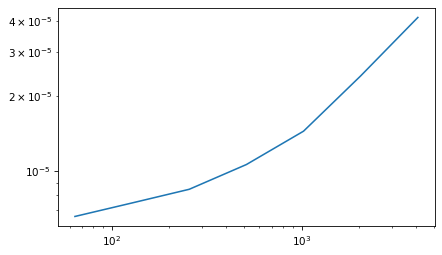

In [35]:
bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

This implementation of dct is even faster.
The line is curved, which means either we haven't seen the asymptotic behavior yet, or the asymptotic behavior is not a simple exponent of $n$.
In fact, as we'll see soon, the run time is proportional to $n \log n$.

The following figure shows all three curves on the same axes.

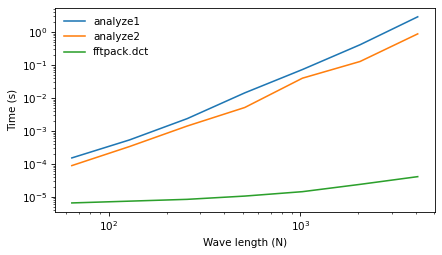

In [36]:
plt.plot(ns, bests, label='analyze1')
plt.plot(ns, bests2, label='analyze2')
plt.plot(ns, bests3, label='fftpack.dct')
decorate(xlabel='Wave length (N)', ylabel='Time (s)', **loglog)

### Exercise 6.2

One of the major applications of the DCT is compression for both sound and images.
In its simplest form, DCT-based compression works like this:

1. Break a long signal into segments.
2. Compute the DCT of each segment.
3. Identify frequency components with amplitudes so low they are inaudible, and remove them.
Store only the frequencies and amplitudes that remain.
4. To play back the signal, load the frequencies and amplitudes for each segment and apply the inverse DCT.

Implement a version of this algorithm and apply it to a recording of music or speech.
How many components can you eliminate before the difference is perceptible?

`thinkdsp` provides a class, `Dct` that is similar to a `Spectrum`, but which uses DCT instead of FFT.

As an example, I'll use a recording of a saxophone:

In [37]:
download('https://github.com/AllenDowney/ThinkDSP/raw/master/code/100475__iluppai__saxophone-weep.wav')

In [38]:
from thinkdsp import read_wave

wave = read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()

Here's a short segment:

In [39]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

And here's the DCT of that segment:

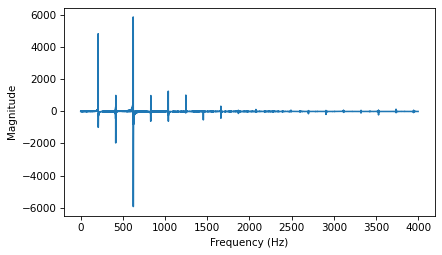

In [40]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate_freq()

There are only a few harmonics with substantial amplitude, and many entries near zero.

The following function takes a DCT and sets elements below `thresh` to 0.

In [41]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

If we apply it to the segment, we can eliminate more than 90% of the elements:

20457	22050	92.77551020408163


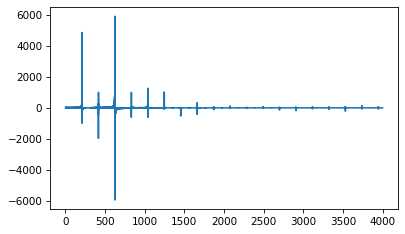

In [42]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

And the result sounds the same (at least to me):

In [43]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

To compress a longer segment, we can make a DCT spectrogram.
The following function is similar to `wave.make_spectrogram` except that it uses the DCT.

In [44]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    """Computes the DCT spectrogram of the wave.

    seg_length: number of samples in each segment

    returns: Spectrogram
    """
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    # map from time to Spectrum
    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        # the nominal time for this segment is the midpoint
        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Now we can make a DCT spectrogram and apply `compress` to each segment:

In [45]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.2)

1018	1024	99.4140625
1016	1024	99.21875
1014	1024	99.0234375
1017	1024	99.31640625
1016	1024	99.21875
1017	1024	99.31640625
1016	1024	99.21875
1020	1024	99.609375
1014	1024	99.0234375
1005	1024	98.14453125
1009	1024	98.53515625
1015	1024	99.12109375
1015	1024	99.12109375
1016	1024	99.21875
1016	1024	99.21875
1015	1024	99.12109375
1017	1024	99.31640625
1020	1024	99.609375
1013	1024	98.92578125
1017	1024	99.31640625
1013	1024	98.92578125
1017	1024	99.31640625
1018	1024	99.4140625
1015	1024	99.12109375
1013	1024	98.92578125
794	1024	77.5390625
785	1024	76.66015625
955	1024	93.26171875
995	1024	97.16796875
992	1024	96.875
976	1024	95.3125
925	1024	90.33203125
802	1024	78.3203125
836	1024	81.640625
850	1024	83.0078125
882	1024	86.1328125
883	1024	86.23046875
891	1024	87.01171875
901	1024	87.98828125
902	1024	88.0859375
900	1024	87.890625
900	1024	87.890625
894	1024	87.3046875
904	1024	88.28125
901	1024	87.98828125
915	1024	89.35546875
913	1024	89.16015625
899	1024	87.79296875
905	1024	88.37

861	1024	84.08203125
881	1024	86.03515625
882	1024	86.1328125
874	1024	85.3515625
875	1024	85.44921875
866	1024	84.5703125
870	1024	84.9609375
883	1024	86.23046875
870	1024	84.9609375
871	1024	85.05859375
877	1024	85.64453125
866	1024	84.5703125
877	1024	85.64453125
863	1024	84.27734375
873	1024	85.25390625
871	1024	85.05859375
883	1024	86.23046875
862	1024	84.1796875
853	1024	83.30078125
858	1024	83.7890625
857	1024	83.69140625
855	1024	83.49609375
847	1024	82.71484375
837	1024	81.73828125
850	1024	83.0078125
864	1024	84.375
879	1024	85.83984375
883	1024	86.23046875
871	1024	85.05859375
888	1024	86.71875
881	1024	86.03515625
830	1024	81.0546875
870	1024	84.9609375
877	1024	85.64453125
886	1024	86.5234375
863	1024	84.27734375
871	1024	85.05859375
886	1024	86.5234375
871	1024	85.05859375
896	1024	87.5
872	1024	85.15625
870	1024	84.9609375
877	1024	85.64453125
863	1024	84.27734375
886	1024	86.5234375
898	1024	87.6953125
884	1024	86.328125
908	1024	88.671875
878	1024	85.7421875
865	1024	8

In most segments, the compression is 75-85%.

To hear what it sounds like, we can convert the spectrogram back to a wave and play it.

In [46]:
wave2 = spectro.make_wave()
wave2.make_audio()

And here's the original again for comparison.

In [47]:
wave.make_audio()

As an experiment, you might try increasing `thresh` to see when the effect of compression becomes audible (to you).

Also, you might try compressing a signal with some noisy elements, like cymbals.

[Think DSP: Digital Signal Processing in Python, 2nd Edition](https://allendowney.github.io/ThinkDSP2/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)